In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-06-17 18:57:12.755529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-17 18:57:13.258055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-17 18:57:13.258076: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-17 18:57:14.896441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
ls Grape

 Grape/                          'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'/
 Grape___Black_rot/               Grape___healthy/
'Grape___Esca_(Black_Measles)'/


In [3]:
import os

num_skipped = 0
for folder_name in ("Grape___Black_rot","Grape___Esca_(Black_Measles)","Grape___healthy","Grape___Leaf_blight_(Isariopsis_Leaf_Spot)"):
    folder_path = os.path.join("Grape", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Grape",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5164 files belonging to 5 classes.
Using 4132 files for training.
Using 1032 files for validation.


2023-06-17 18:57:20.291713: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-17 18:57:20.292294: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-17 18:57:20.292420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LEOSER4): /proc/driver/nvidia/version does not exist
2023-06-17 18:57:20.294638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


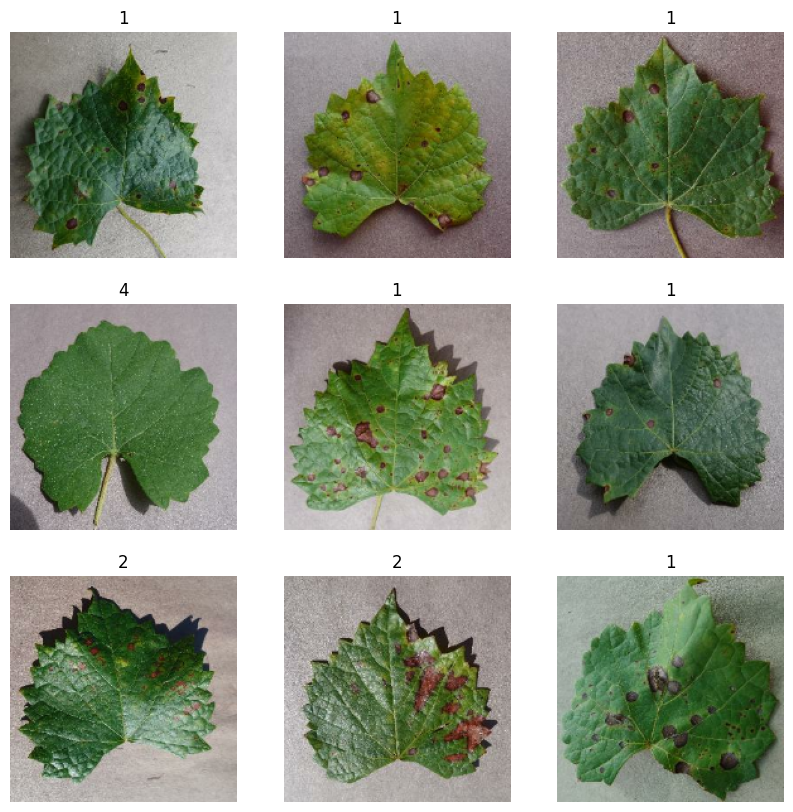

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

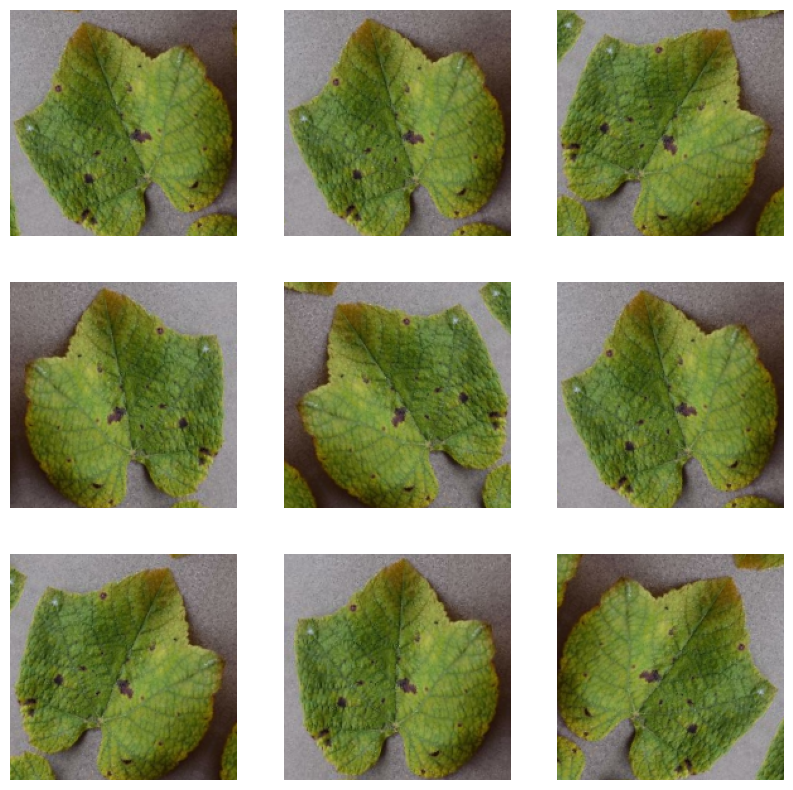

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

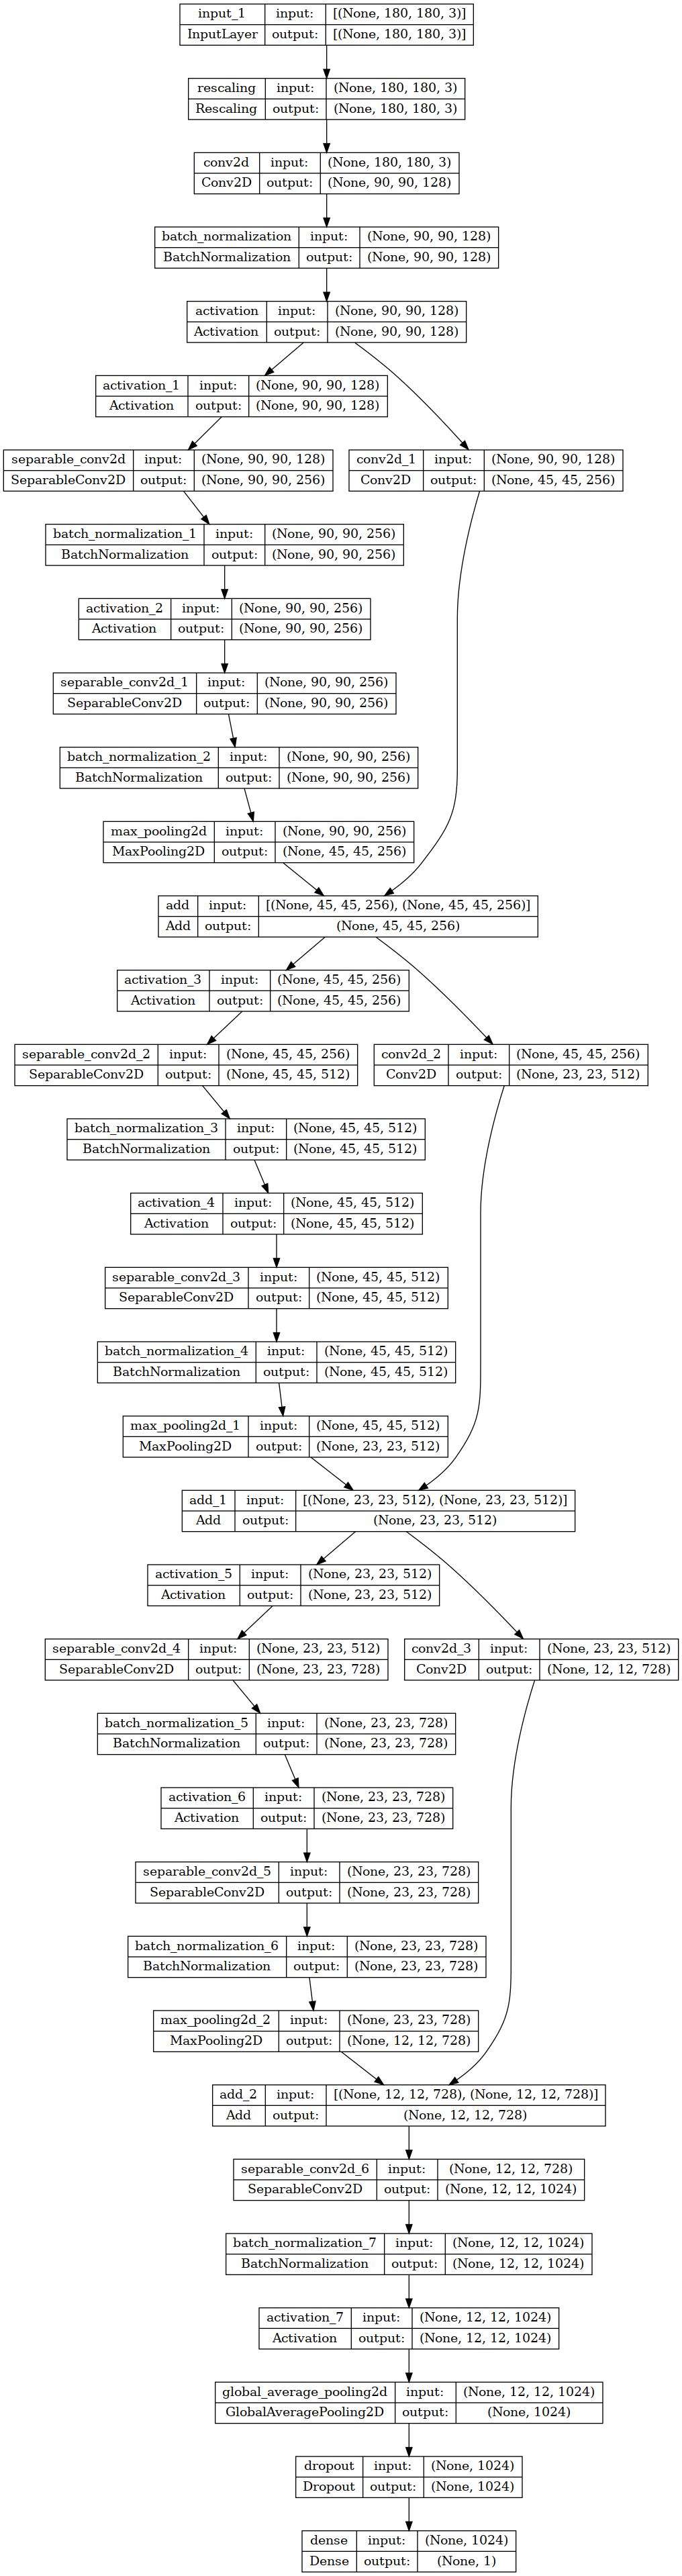

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [11]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
33/33 [==============================] - 599s 18s/step - loss: -16.7049 - accuracy: 0.1718 - val_loss: -1.5713 - val_accuracy: 0.2946
Epoch 2/25
33/33 [==============================] - 577s 17s/step - loss: -51.4359 - accuracy: 0.2800 - val_loss: -3.5793 - val_accuracy: 0.2946
Epoch 3/25
33/33 [==============================] - 564s 17s/step - loss: -92.0042 - accuracy: 0.2899 - val_loss: -5.1098 - val_accuracy: 0.2946
Epoch 4/25
33/33 [==============================] - 532s 16s/step - loss: -147.7040 - accuracy: 0.2916 - val_loss: -6.6079 - val_accuracy: 0.2946
Epoch 5/25
33/33 [==============================] - 549s 16s/step - loss: -221.5514 - accuracy: 0.2916 - val_loss: -8.8180 - val_accuracy: 0.2946
Epoch 6/25
33/33 [==============================] - 549s 16s/step - loss: -305.4582 - accuracy: 0.2916 - val_loss: -17.9489 - val_accuracy: 0.2946
Epoch 7/25
33/33 [==============================] - 550s 17s/step - loss: -404.7810 - accuracy: 0.2916 - val_loss: -32.5065 - 

In [14]:
img = keras.preprocessing.image.load_img(
    "/home/trabalhof/Grape/Grape___Black_rot/14.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis



predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% Grape___Black_rot , {100 * score:.2f}% Grape___Esca_(Black_Measles) .{100 * score:.2f}% Grape___healthy and {100 * score:.2f}% Grape___Leaf_blight_(Isariopsis_Leaf_Spot)")

